# Categorical preprocessing
> How to deal with categorical data for tree based algorithms

- toc: true 
- badges: true
- comments: true
- author: Martynas Lozys
- categories: [sklearn, pipeline, preprocessing, categorical]

In [1]:
import pandas as pd
import numpy as np

# Load and inspect data

The purpose of this notebook is not to get to the leaderboard, but rather explore various categorical preprocessing techniques, while choosing some heuristics for other modelling decisions.  

I will examine the following categorical encoding techniques:
* one hot
* ordinal
* target

In [2]:
df = pd.read_csv('../input/home-credit-default-risk/application_train.csv')

In [3]:
df.shape

(307511, 122)

In [4]:
df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [5]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
import pylab
import matplotlib.pyplot as plt

def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (15, 8)
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns');

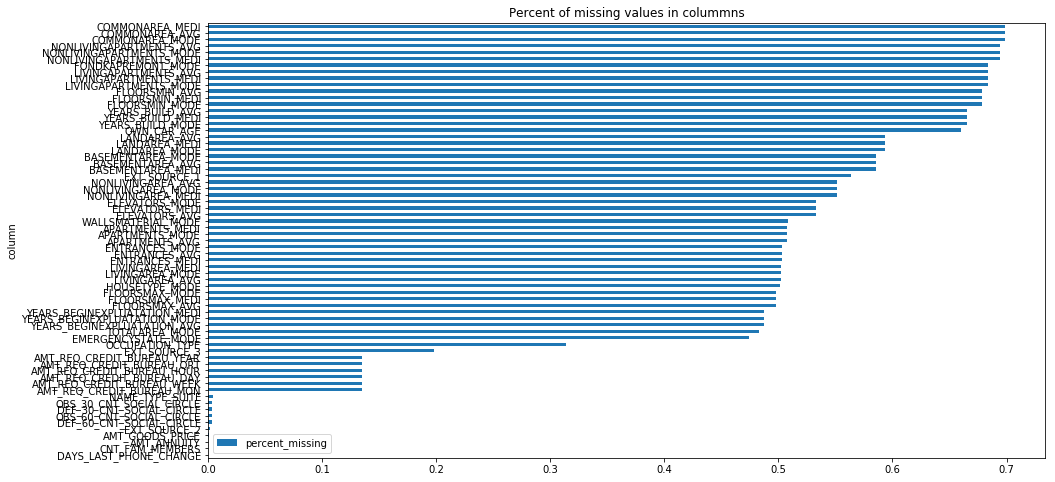

In [7]:
plot_missing_values(df)

In [8]:
f'Total missing values: {df.isnull().sum().sum()}'

'Total missing values: 9152465'

In [9]:
df.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

Ok, so it's not a terribly large dataset, with mixed variable types, considerable amount of missing values and imbalanced target classes.  

# Sampling

First of all, I'd like to downsample dominant target class to reduce imbalance.
Typically, we don't need 1:1 ratio of positive to negative class, because that will most likely result in considerable information loss, however, I'll use it here to speed up development.

In [10]:
def downsample_df(df, target_col):
    positive_class = df[df[target_col] == 1]
    negative_class = (df[df[target_col] == 0]
                      .sample(n=positive_class.shape[0],
                              random_state=42))
    return pd.concat([positive_class, negative_class], axis=0)

In [11]:
sampled_df = downsample_df(df, 'TARGET')

In [12]:
print(sampled_df.shape)
sampled_df.TARGET.value_counts()

(49650, 122)


1    24825
0    24825
Name: TARGET, dtype: int64

# Split train and validation sets

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
y = sampled_df.TARGET
X = sampled_df.drop('TARGET', axis=1)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((39720, 121), (9930, 121), (39720,), (9930,))

# Establish baseline

Any fruitful experimentation must begin by first setting a reasonable baseline result and then trying to beat it.  
So let's contruct a basic pipeline that provides us the benchmark, while also simplifying experimentation.

## Preprocessing

Before we can get our first score on the validation set, we need to make sure that the data is in the right format to be ingested by the model, i.e. all columns should be numericalized and have no missing values.

For dealing with missing values let's just simply fill categorical NAs with 'none' value and numericals with median.
More elaborate schemes for missing value imputation are not in the scope of this notebook and can be found here: https://marloz.github.io/projects/sklearn/pipeline/missing/preprocessing/2020/03/20/sklearn-pipelines-missing-values.html  

For conversion of categoricals into numerics, I'll use OneHotEncoder first, as it has in-built functionality of handling unseen classes, when applying pipeline to out-of-sample data.

In [16]:
def get_categorical_columns(X):
    return [col for col in X.columns if X[col].dtypes == 'O']

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

cat_imputer = SimpleImputer(strategy='constant', fill_value='none')
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
cat_processor = Pipeline([
    ('imputer', cat_imputer),
    ('encoder', ohe)
])

num_imputer = SimpleImputer(strategy='median')

preprocessor = ColumnTransformer([('categoricals', cat_processor, get_categorical_columns)],
                                 remainder=num_imputer)

In [18]:
_ = pd.DataFrame(preprocessor.fit_transform(X_train))
print(f'Number of missing values after imputatation {_.isnull().sum().sum()}')
print(f'All data types are numeric: {sum(_.dtypes == float) == _.shape[1]}')

Number of missing values after imputatation 0
All data types are numeric: True


## Model

For modelling let's bring out yer good 'ol RandomForestClassifier, as it's very widely used, requires little preprocessing and performs well with very little tuning, which is just perfect for such exploration.

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

In [20]:
pipeline.fit(X_train, y_train)
pipeline.score(X_valid, y_valid)

0.6756294058408862

Okay, so this gives us a plain vanilla pipeline score, let's see if we can squeeze out some improvement!

* # Combine rare categories

One of the simpler techniques that we can start with is combining rare classes, to avoid creating a bunch of sparse OHE columns, which doesn't help the model (for more see here https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769)

Let's first check how many variables have rare categories as this may not be issue at all in this case.
There are only few variables that have categories with counts < 100, so probably this technique will not add much.

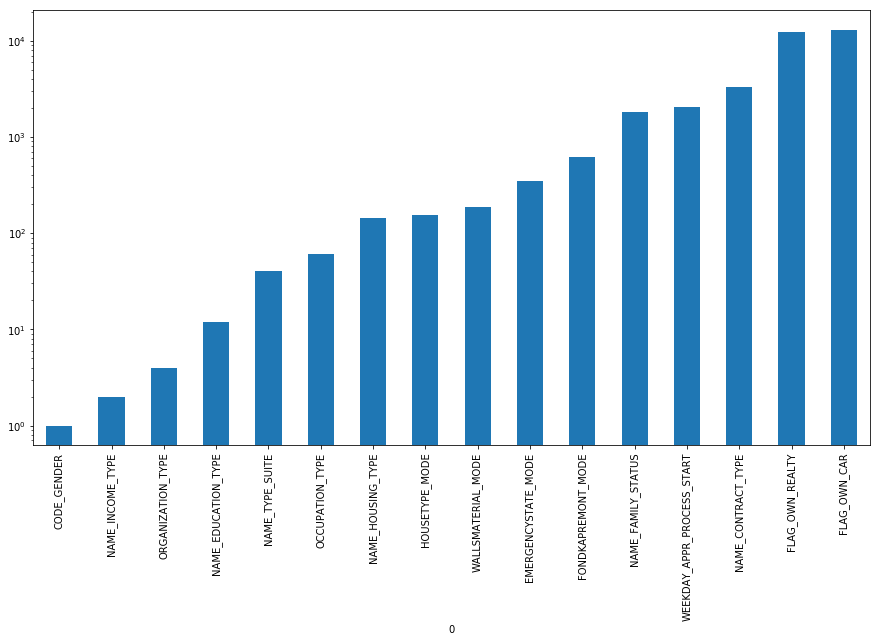

In [21]:
min_count_categories = [(col, X_train[col].value_counts().min()) for col in get_categorical_columns(X_train)]
pd.DataFrame(min_count_categories).set_index(0)[1].sort_values().plot(kind='bar')
plt.yscale('log')

Also it's worth doing cardinality check, as noted in the beginning of the section, categorical variables with many levels can cause issues for tree based algorithms, especially when One Hot Encoding is applied.
    There's only a single variable, which has close to 60 categories, which is not too bad, so One Hot Encoding might actually be quite suitable in this case.

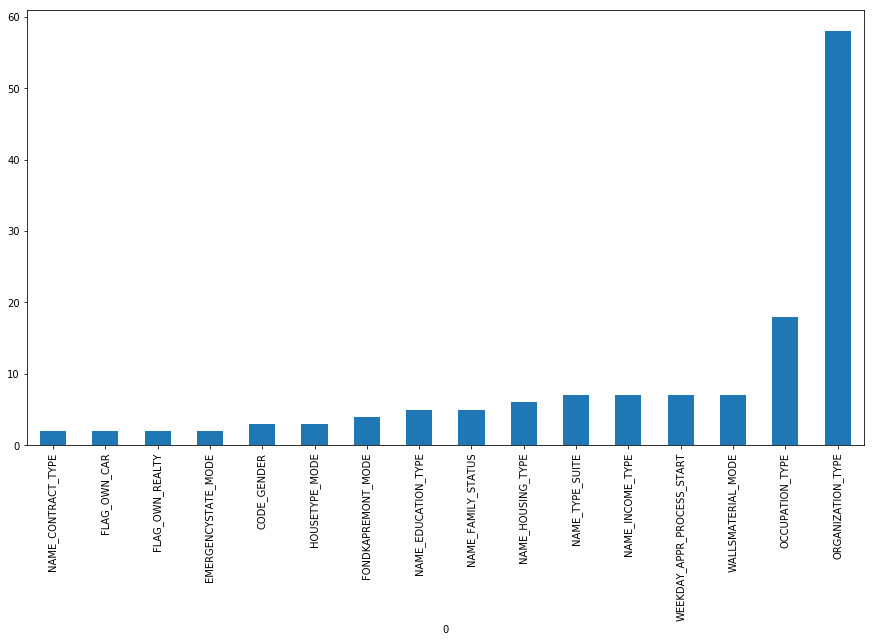

In [22]:
unique_counts = [(col, X_train[col].nunique()) for col in get_categorical_columns(X_train)]
pd.DataFrame(unique_counts).set_index(0)[1].sort_values().plot(kind='bar')

Let's still apply rare category combiner, just to see how it works and have it in the toolbox.

In [23]:
def combine_low_count_classes(X, threshold=100):
    """ This is a transformer function inteded to be used on categorical columns without any missing values.
    It loops through variables and checks for categories that have related counts lower than specified threshold.
    Then it combines all these low count categories into single 'other' category,
    along with first category above the threshold"""
    X = pd.DataFrame(X)
    for column in X.columns:
        frequencies = X[column].value_counts()
        if frequencies.min() < threshold:
            lower_bound = frequencies[frequencies >= threshold].min()
            mask = frequencies[frequencies <= lower_bound].index
            replace_dict = dict.fromkeys(mask, 'other')
            X[column] = X[column].replace(replace_dict)
    return X.values

In [24]:
from sklearn.preprocessing import FunctionTransformer

combiner = FunctionTransformer(combine_low_count_classes)

In [25]:
cat_processor = Pipeline([
    ('imputer', cat_imputer),
    ('combiner', combiner),
    ('encoder', ohe)
])
pipeline.set_params(**{'preprocessor__categoricals': cat_processor});

In [26]:
pipeline.fit(X_train, y_train)
pipeline.score(X_valid, y_valid)

0.6717019133937563

Ok, this actually made the score slightly worse. As argued above, rare categories and high cardinality is probably not the main concern for this dataset, so this technique removes more information than noise.

# Ordinal encoding

Ordinal encoder doesn't handle unseen data, so the pipeline will fail on validation set. To accomodate for this we need to replace new categories in validation set with some value and append this replaced value to the known classes of fitted encoder (inspired by https://stackoverflow.com/questions/40321232/handling-unknown-values-for-label-encoding)

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder

class CustomLabelEncoder(BaseEstimator, TransformerMixin):
    """ Fits sklearn's OrdinalEncoder (OE) to categorical columns without missing values.
    Loops through columns and checks if each category is in within fitted OE categories.
    If not, new category is assigned 'new_category' value and appended to OE categories,
    such that OE can be applied to unseen data."""
    
    def fit(self, X, y=None):
        self.oe = OrdinalEncoder()
        self.oe.fit(X)
        return self
    
    def transform(self, X):
        for col_idx in range(X.shape[1]):
            X[:, col_idx] = self.replace_new_categories(X[:, col_idx], self.oe.categories_[col_idx])
            self.oe.categories_[col_idx] = np.append(self.oe.categories_[col_idx], 'new_category')
        return self.oe.transform(X)
    
    def replace_new_categories(self, col, categories):
        return pd.Series(col).map(lambda current_category: 'new_category' 
                                  if current_category not in categories 
                                  else current_category).values

In [28]:
cat_processor = Pipeline([
    ('imputer', cat_imputer),
    ('encoder', CustomLabelEncoder())
])
pipeline.set_params(**{'preprocessor__categoricals': cat_processor});

In [29]:
pipeline.fit(X_train, y_train)
pipeline.score(X_valid, y_valid)

0.6748237663645519

No improvement from the benchmark, but scores are pretty close.

# Target encoding
Another popular way of dealing with categoricals is Target Encoding, which basically includes information about the mean of the dependent variable as it relates to particular category. We have to be careful though not to leak data from validation set and also consider the number of values per category as some small groups can introduce noise (a concept akin to combining rare classes discussed before). See more here (https://medium.com/@venkatasai.katuru/target-encoding-done-the-right-way-b6391e66c19f)

In [30]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    """ Calculates global mean on train set, then proceeds with creating encoding dictionary
    for each column, which contains smoothed target variable mean for each category.
    The smoothing parameter can be changed upon initiation of the class and represents
    number of values per category, i.e. for rare categories global mean has more weight.
    
    Transform part uses same trick as customized Ordinal Encoder used above - 
    checking for new categories in data and assigning them global mean.
    """
    
    def __init__(self, smooth_weight=100):
        self.smooth_weight = smooth_weight
    
    def fit(self, X, y):
        self.global_mean = np.mean(y)
        self.enc_dict = self.create_encoding_dict(X, y)
        return self
    
    def create_encoding_dict(self, X, y):
        enc_dict = {}
        for col_idx in range(X.shape[1]):
            enc_dict[col_idx] = self.get_smooth_means_for_col(X[:, col_idx], y)
        return enc_dict
    
    def get_smooth_means_for_col(self, col, y):
        smooth_mean_agg = (lambda x: (x['count'] * x['mean'] + self.smooth_weight * self.global_mean) 
                           / (x['count'] + self.smooth_weight))
        col_y_concat = pd.concat([pd.Series(col, name='col'), pd.Series(y, name='target')], axis=1)
        return (col_y_concat.groupby('col')['target'].agg(['count', 'mean'])
               .assign(smooth_mean=smooth_mean_agg))['smooth_mean'].to_dict()
    
    def transform(self, X):
        for col_idx in range(X.shape[1]):
            X[:, col_idx] = self.replace_new_categories(X[:, col_idx], self.enc_dict[col_idx].keys())
            X[:, col_idx] = (pd.Series(X[:, col_idx]).map(self.enc_dict[col_idx])
                             .fillna(self.global_mean).values)
        return X
    
    def replace_new_categories(self, col, categories):
        return pd.Series(col).map(lambda current_category: 'new_category' 
                                  if current_category not in categories 
                                  else current_category).values

In [31]:
cat_processor = Pipeline([
    ('imputer', cat_imputer),
    ('encoder', TargetEncoder())
])
pipeline.set_params(**{'preprocessor__categoricals': cat_processor});

In [32]:
pipeline.fit(X_train, y_train)
pipeline.score(X_valid, y_valid)

0.6780463242698892

Slight improvement from benchmark, which is always nice.  

Thanks for reading, comments are appreciated!